# Данный проект проходит в рамках учебного соревнования 
https://www.kaggle.com/c/sf-dst-restaurant-rating/data

![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime
import re 
from collections import Counter
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [37]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [38]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [39]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [40]:
#  Добавим дополнительные данные
worldcities = pd.read_csv('worldcities.csv')
сost_of_living_index = pd.read_csv('Cost_of_living_index.csv')

In [41]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [42]:
# отметим колонки которые будем удалять
drop_col = ['Restaurant_id', 'Cuisine Style' , 'Price Range',
            'Reviews', 'URL_TA', "ID_TA"] 

In [43]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [44]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [45]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [46]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [47]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [48]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [50]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
25115,id_14325,London,"['European', 'British']",14336.0,$$ - $$$,70.0,"[['An average afternoon tea.', 'Afternoon tea'...",/Restaurant_Review-g186338-d7234467-Reviews-Re...,d7234467,1,3.0
6888,id_6888,Warsaw,"['Polish', 'European']",964.0,$$$$,11.0,"[['Great treat', 'GREAT AS FOR HOTEL'], ['12/1...",/Restaurant_Review-g274856-d10621414-Reviews-P...,d10621414,0,0.0
36684,id_210,Bratislava,"['European', 'Czech', 'Hungarian']",211.0,$,5.0,"[['Perfect shop in Bratislava', 'I stop by eve...",/Restaurant_Review-g274924-d12342846-Reviews-P...,d12342846,1,5.0
2390,id_2390,Paris,NaN,5553.0,NaN,81.0,"[[""Excellent choice of 'proper' beers"", 'Great...",/Restaurant_Review-g187147-d2142583-Reviews-Br...,d2142583,0,0.0
12427,id_5126,Rome,['Italian'],5127.0,$$ - $$$,84.0,"[['Family Sunday lunch', 'Great food, great se...",/Restaurant_Review-g187791-d1051068-Reviews-Cl...,d1051068,1,3.5


In [51]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Предобработка внешней информации.

# worldcities - Население

In [52]:
worldcities.head()


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,Delhi,admin,29617000.0,1356872604
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,Mahārāshtra,admin,23355000.0,1356226629
4,Manila,Manila,14.6000,120.9833,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140


In [53]:
worldcities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41001 entries, 0 to 41000
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        41001 non-null  object 
 1   city_ascii  41001 non-null  object 
 2   lat         41001 non-null  float64
 3   lng         41001 non-null  float64
 4   country     41001 non-null  object 
 5   iso2        40970 non-null  object 
 6   iso3        41001 non-null  object 
 7   admin_name  40902 non-null  object 
 8   capital     9483 non-null   object 
 9   population  40263 non-null  float64
 10  id          41001 non-null  int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 3.4+ MB


In [54]:
#замена наименований городов
worldcities.loc[worldcities.city_ascii == 'Porto', 'city_ascii'] = 'Oporto'
worldcities.loc[worldcities.city_ascii == 'Zürich', 'city_ascii'] = 'Zurich' 
worldcities.loc[worldcities.city_ascii == 'Kraków', 'city_ascii'] = 'Krakow'

In [55]:
# из дополнительного датасета по населению городов выбираем только нужные нам города Европы
worldcities = worldcities[(worldcities.city_ascii.isin(data.City.unique()))&
                  (worldcities.country != 'United States') &
                  (worldcities.country != 'Canada') &
                  (worldcities.country != 'Venezuela') &
                  (worldcities.country != 'Philippines') &
                  (worldcities.country != 'Colombia') &
                  (worldcities.country != 'Brazil')]
# удаляем ненужные столбцы
worldcities = worldcities.drop(['city', 'lat','lng','country','iso2','iso3','admin_name','id','capital'], axis=1)

In [56]:
worldcities

,city_ascii,population
34,Paris,11020000.0
35,London,10979000.0
101,Madrid,6026000.0
169,Barcelona,4588000.0
218,Berlin,3644826.0
282,Rome,2872800.0
403,Vienna,1911191.0
417,Hamburg,1841179.0
427,Warsaw,1790658.0
433,Brussels,1743000.0


In [57]:
worldcities.describe()

,population
count,3.100000e+01
mean,1.998204e+06
std,2.744416e+06
min,1.245090e+05
25%,5.113730e+05
50%,9.726470e+05
75%,1.815918e+06
max,1.102000e+07


Пропусков нету. Явные выбросы не обнаружены Данные можно вносить в наш дата фрейм.

# сost_of_living_index

In [58]:
сost_of_living_index.drop(сost_of_living_index[
    сost_of_living_index.City == 'London, Canada'].index, inplace = True)

In [59]:
# в датасете уровня жизни городов обрезаем в колоне City название города
сost_of_living_index.City = сost_of_living_index.City.apply(lambda x:x.split(',')[0])
# Преобразуем название городов которые не совпадают с названьями в тестовом дата фрейме
сost_of_living_index.loc[сost_of_living_index.City == 'Krakow (Cracow)', 'City'] = 'Krakow'
сost_of_living_index.loc[сost_of_living_index.City == 'Porto','City'] = 'Oporto'
# из дополнительного датасета по населению городов выбираем только нужные нам города Европы
сost_of_living_index = сost_of_living_index[(сost_of_living_index.City.isin(data.City.unique()))] 
сost_of_living_index

,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
1,2,Zurich,128.65,62.62,97.39,127.35,127.14,142.39
5,6,Geneva,118.33,69.16,95.06,112.08,119.78,133.47
9,10,Oslo,107.14,48.58,79.42,93.81,114.42,104.30
19,20,Copenhagen,87.91,47.84,68.94,64.59,113.18,114.05
21,22,Luxembourg,86.85,61.31,74.76,70.75,99.49,120.25
25,26,Paris,84.68,47.60,67.13,73.77,88.11,95.38
30,31,Amsterdam,82.14,54.65,69.13,62.35,87.71,98.88
33,34,London,81.31,70.30,76.10,57.74,91.85,100.22
35,36,Helsinki,80.60,35.69,59.34,61.31,94.99,108.83
38,39,Dublin,80.28,60.12,70.73,60.82,87.98,89.32


In [60]:
сost_of_living_index.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 1 to 400
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Rank                            31 non-null     int64  
 1   City                            31 non-null     object 
 2   Cost of Living Index            31 non-null     float64
 3   Rent Index                      31 non-null     float64
 4   Cost of Living Plus Rent Index  31 non-null     float64
 5   Groceries Index                 31 non-null     float64
 6   Restaurant Price Index          31 non-null     float64
 7   Local Purchasing Power Index    31 non-null     float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.2+ KB


In [61]:
сost_of_living_index.describe()

,Rank,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,159.000000,72.029032,37.400968,55.637097,58.735806,74.490323,93.318387
std,136.191042,20.757017,15.902482,17.665159,21.422128,25.842947,23.130058
min,2.000000,39.530000,12.730000,29.020000,29.920000,33.780000,52.480000
25%,35.000000,58.230000,25.605000,40.700000,44.765000,54.530000,75.605000
50%,120.000000,72.150000,33.440000,54.020000,57.740000,78.140000,96.070000
75%,292.500000,80.955000,47.720000,68.035000,64.100000,88.045000,111.260000
max,401.000000,128.650000,70.300000,97.390000,127.350000,127.140000,142.390000


Пропусков нету. Явные выбросы не обнаружены Данные можно вносить в наш дата фрейм.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

Пройдемся по каждому столбцу, и познакомимся с данными по ближе.

# Restaurant_id 

In [62]:
# Посмотрим количество уникальных значений и их количество
data.Restaurant_id.value_counts()

id_227      19
id_633      19
id_436      19
id_871      19
id_585      18
            ..
id_14655     1
id_14405     1
id_15809     1
id_14855     1
id_11658     1
Name: Restaurant_id, Length: 13094, dtype: int64

In [63]:
yyy = data[['Restaurant_id',"Rating" ]].groupby("Restaurant_id")

В общем дата фрейме предоставлено 50000 строк, а у нас всего 13094 уникальных значений ID, отметим, что у нас есть сетевые рестораны, либо у ресторанов один владелец. Отсутствуют пропуски в признаке.

# City

In [64]:
# Посмотрим количество уникальных значений и их количество
print('Количество уникальных городов', len(data.City.unique()))
data.City.value_counts()

Количество уникальных городов 31


London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

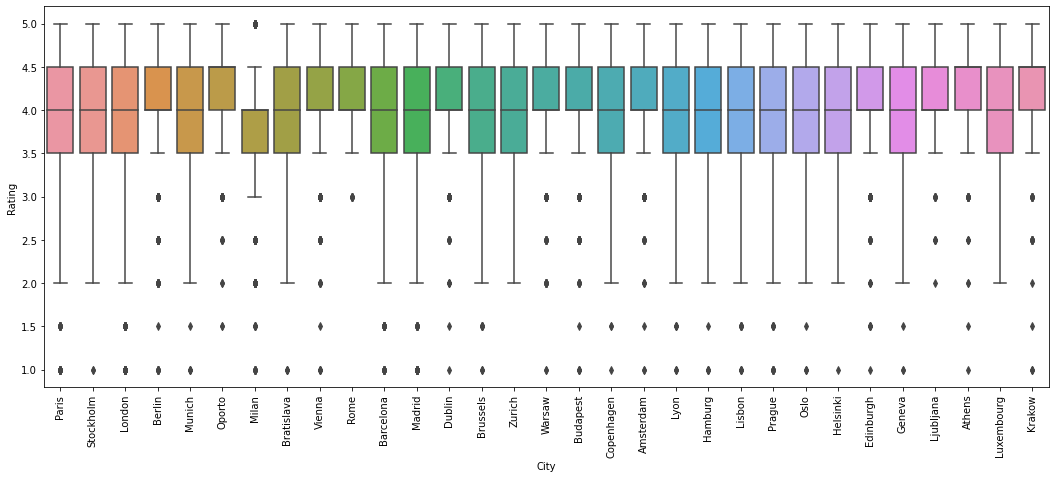

In [65]:
plt.figure(figsize=(18, 7))
sns.boxplot(x='City', y='Rating', data=data[data['sample'] == 1])
plt.xticks(rotation=90);

В дата фрейме 31 уникальный город. Отсутствуют пропуски в признаке.    
Отметим, у Рима самые высокие оценки.

# **Cuisine Style**

Первый столбце, где есть пропуски это Cuisine Style. Отметим данные пропуски в отдельном столбце. Предположим, что в данных ресторанах предложена местная кухня и заполним её значением значением local.

In [66]:
data['Number_of_Cuisine_Style_isNAN'] = pd.isna(data['Cuisine Style']).\
                                        astype('uint8')

In [67]:
data['Cuisine Style'].fillna("local", inplace=True)

# *Price Range*

В связи с тем, что в данных есть сетевые ресторыны, применим следующую логику.      
    1) для начала отметим все данные где есть пропуски.     
    2) если ресторан сетевой. То ставиь наиболее популярный ценовой рейтинг в данной сети.    
    3) если ресторан только один, то ставим минимальный рейнитинг.     

In [68]:
data['Price_Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')

Создадим список, который будет хранить ID ресторана и наиболее популярную категорию цену.
Пропуски сразу заполним "$"

In [69]:
most_com_price = data[["Restaurant_id", "Price Range"]].\
groupby("Restaurant_id").apply(lambda x: x.mode()).fillna("$")

Далее напишем код, который будет возвращать нам значение в соответствии с заданной нами логикой. И сразу же применим его к дата фрейму.

In [70]:
                                                                        
def fill_price_na(x):
    '''Код принимает в себя всю строку и возращает значение
    price range в зависемости нулевое это значение или нет'''
    if pd.isna(x['Price Range']):
        return most_com_price.loc[x["Restaurant_id"]]["Price Range"][0]
    else:
        return x["Price Range"]

In [71]:
data["Price Range"] = data.apply(lambda x: fill_price_na(x), axis = 1)

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Restaurant_id                  50000 non-null  object 
 1   City                           50000 non-null  object 
 2   Cuisine Style                  50000 non-null  object 
 3   Ranking                        50000 non-null  float64
 4   Price Range                    50000 non-null  object 
 5   Number of Reviews              46800 non-null  float64
 6   Reviews                        49998 non-null  object 
 7   URL_TA                         50000 non-null  object 
 8   ID_TA                          50000 non-null  object 
 9   sample                         50000 non-null  int64  
 10  Rating                         50000 non-null  float64
 11  Number_of_Cuisine_Style_isNAN  50000 non-null  uint8  
 12  Price_Range_isNAN              50000 non-null 

# **Number of Reviews**

Данный столбик неразрывно связан с Reviews. Так же при более детальном просмотре, можно заметить, что в некоторых строках у нас есть комментарии, хотя их фактическое количество не указано.

In [73]:
# Например
data.iloc[74]

Restaurant_id                                                                id_74
City                                                                        Prague
Cuisine Style                                        ['Cafe', 'European', 'Czech']
Ranking                                                                     2052.0
Price Range                                                                      $
Number of Reviews                                                              NaN
Reviews                                           [["Nova' Doba"], ['01/26/2017']]
URL_TA                           /Restaurant_Review-g274707-d12032989-Reviews-C...
ID_TA                                                                    d12032989
sample                                                                           0
Rating                                                                         0.0
Number_of_Cuisine_Style_isNAN                                                    0
Pric

Поэтому будем использовать следующий подход к заполнению пропусков.    
Оставлять значение если оно указано.    
Если значение не указано, будем проверять есть ли комментарии в Reviews, подсчитывать их и возвращать значение комментариев либо 0 если пусто.    
Отметим, что в данных указано максимально 2 комментария в столбцу Reviews.   
А все пустые значение Reviews отмечены как [[], []], и длинна такой строки составляет 8. Больше комментариев с такой длинной нету. Поэтому пропуск можно вычислить по длине строки.
Количество комментариев (1 или 2) можно вычислить через функцию сплит.
Т.к. если в столбце указан два комментария, то используется шаблон "[['Good for a quick lunch', 'A good option'], ['01/10/2018', '12/29/2017']]", и если использовать сплит по ("', '"), то у нас получится лист длинной 3.    
При одном комментарии в столбце используется маска "[['Good, not Great'], ['01/20/2015']]"Если использовать такой же сплит этой маске, то получим лист с длинной один.  
Первым делом отметим все пропущенные значения.

In [74]:
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews'])\
                                  .astype('uint8')

Снова напишем функцию для заполнения. 

In [75]:
def fill_Number_of_Reviews(x):
    '''функция принимает в себя строку, и проверяет есть ли комментарии 
    в Reviews и возвращает соответствующие значение'''
    
    if pd.isna(x["Number of Reviews"]):
        if pd.isna(x["Reviews"]):
            return 0
        if len(x["Reviews"]) == 8:
            return 0
        else:
            list_ = x["Reviews"].split("', '")
            if len(list_) == 3:
                return 2
            else:
                return 1
    else:
        return x["Number of Reviews"]

In [76]:
data["Number of Reviews"] = data.apply(lambda x: fill_Number_of_Reviews(x),
                                       axis=1)

Теперь посмотрим на распределение признака.

In [77]:
data["Number of Reviews"].describe()

count    50000.000000
mean       116.528560
std        286.163568
min          0.000000
25%          7.000000
50%         28.000000
75%        105.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

In [78]:
# Посмотрим на моду
data["Number of Reviews"].mode()

0    2.0
dtype: float64

<AxesSubplot:>

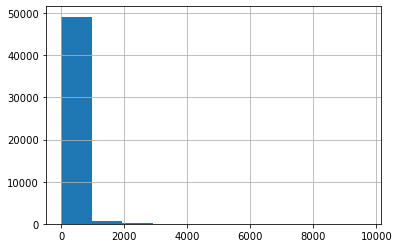

In [79]:
data["Number of Reviews"].hist()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Number of Reviews'>

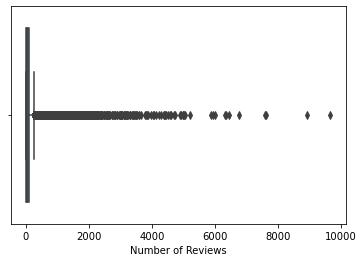

In [80]:
sns.boxplot(data["Number of Reviews"])

Принимаем решение, все значение свыше 200 будет объединены в одну группу. И присвоим им значение рейтинга равное 200.

In [81]:
data["Number of Reviews"] = data["Number of Reviews"].apply(lambda x:
                                                            200 if x>200 else x)

# **Reviews**

Reviews содержит всего 2 Nan, заполним пропуски пустой строкой.

In [82]:
data['Reviews'].fillna("[[], []]", inplace=True)

In [83]:
# Проверим ещё раз данные на пропуски
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Restaurant_id                  50000 non-null  object 
 1   City                           50000 non-null  object 
 2   Cuisine Style                  50000 non-null  object 
 3   Ranking                        50000 non-null  float64
 4   Price Range                    50000 non-null  object 
 5   Number of Reviews              50000 non-null  float64
 6   Reviews                        50000 non-null  object 
 7   URL_TA                         50000 non-null  object 
 8   ID_TA                          50000 non-null  object 
 9   sample                         50000 non-null  int64  
 10  Rating                         50000 non-null  float64
 11  Number_of_Cuisine_Style_isNAN  50000 non-null  uint8  
 12  Price_Range_isNAN              50000 non-null 

Все заполнено. Идем дальше

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [84]:
data.nunique(dropna=False)

Restaurant_id                    13094
City                                31
Cuisine Style                    10732
Ranking                          12975
Price Range                          3
Number of Reviews                  201
Reviews                          41857
URL_TA                           49963
ID_TA                            49963
sample                               2
Rating                              10
Number_of_Cuisine_Style_isNAN        2
Price_Range_isNAN                    2
Number_of_Reviews_isNAN              2
dtype: int64

Прежде чем приступить к обработке столбца City мы сгенерируем новый признак - количество ресторанов в одном городе.

#### Возьмем следующий признак "Price Range".

In [85]:
data['Price Range'].value_counts()

$$ - $$$    33436
$           14612
$$$$         1952
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3 

In [86]:
data['Price Range'].value_counts()

$$ - $$$    33436
$           14612
$$$$         1952
Name: Price Range, dtype: int64

In [87]:
code_price_range = {"$$ - $$$": 2, "$": 1, "$$$$": 3}

In [88]:
data["label_encoding_price"] = data['Price Range'].apply(lambda x:
                                                   code_price_range[x])

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработка Cuisine Style

In [89]:
# Преобразуем значение str в лист. 
data["Cuisine Style"] = data["Cuisine Style"].str.replace("'", "")\
                        .str.strip('''['']''').str.split(', ')

In [90]:
# Найдем уникальные значения.
unique_cuisine_style = set()
for list_ in data["Cuisine Style"]:
    unique_cuisine_style.update(list_)

Закодируем данные перед построением модели, дабы не затруднять анализ данных на данном этапе.

### Обработка Reviews

#  Найдем в Reviews даты и занесем их в новый столбки


In [91]:
data['Reviews data'] = data['Reviews'].apply(lambda x:
                                             re.findall(r"\d\d\/\d\d\/\d{4}",
                                                        str(x)))
data[['Date_1','Date_2']] = data['Reviews data'].apply(pd.Series, 1)
data['Date_1'] = pd.to_datetime(data['Date_1'])
data['Date_2'] = pd.to_datetime(data['Date_2'])
# вычислим разницу между датами
data['Delta review'] = abs(data['Date_1'] - data['Date_2'])
# приведем разницу в дни
data['Delta review'] = data['Delta review'].dt.days
# пропуски заполняем средним значением
data['Delta review'].fillna(round(data['Delta review'].mean()), inplace=True)

In [92]:
# Сразу же удалим ненужные столбцы 
data.drop('Date_1', axis=1, inplace=True)
data.drop('Date_2', axis=1, inplace=True)

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
Теперь займемся самым интересным.   
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

Создадим новые признаки. 
1) Количество ресторанов с одним ID. Предположим, что это сетевые рестораны или рестораны с одним владельцем.     
2) Количество ресторанов в одном городе.    
3) Население в городе.   
4) Количество слов, которые придают положительный или негативный оттенок в комментариях.    
5) Добавим признак. Количество кухонь в ресторане.   
6) Отметим столицы.   
7) Присоединим таблицу сost_of_living_index..         
8) Отметим, к какой части Европы относятся города    
9) Отметим топ 10 самых встречающихся городов в выборке    
10) Добавим новый признак. Количество слов в комментариях    
Прежде чем мы начнем считать новые признаки на основе старых, нормализуем числовые признаки.    
11) Добавим признак. Население в городе, деленное на количество ресторанов.    
12) Добавим признак. Население в городе деленное, на количество кухонь.    
13) Добавим признак. Население в городе, деленное на рейтинг стоимости.   
14) Вычисляем относительную позицию ресторана среди всех ресторанов города    
15) Добавим признак. Рейтинг стоимости, умноженный на стоимость жизни     
16) Добавим признак. Рейтинг стоимости, деленный на покупательскую способность    
17) Добавим признак. Покупательскую способность разделим на население    
18) Добавим признак. Как часто оставляют отзывы. Разделим население на количество отзывов    



# 1) Количество ресторанов с одним ID. Предположим, что это сетевые рестораны или рестораны с одним владельцем. 

In [93]:
number_by_ID = data["Restaurant_id"].value_counts()
data["number_by_ID"] = data["Restaurant_id"].apply(
    lambda x: number_by_ID[x])

# 2) Количество ресторанов в одном городе.

In [94]:
# Количество ресторанов в одном городе.
number_by_city = data["City"].value_counts()
data["number_by_city"] = data["City"].apply(
    lambda x: number_by_city[x])

# 3) Население в городе.   

In [95]:
data = data.join(worldcities.set_index('city_ascii'), on='City') 

# 4) Количество слов, которые придают положительный или негативный оттенок в комментариях.    

In [96]:
def count_words(line, words):
    '''Функция принимает на вход строку и список слов
    и возвращает количество слов встреченных в строке из списка '''
    list_count = list()
    for text in line:
        text_words = set(re.findall(r'\w+', text.casefold()))
        test = sum(w in text_words for w in set(map(str.casefold, words)))
        list_count.append(test)
    return list_count


In [97]:
# Список слов с положительным оттенком.
good_words = ['good', 'great', 'nice', 'best', 'excellent', 'delicious',
             'friendly', 'lovely', 'amazing', 'tasty', 'fine',
              'Piping hot', 'Tender' , 'well', 'palatable']

In [98]:
# Список слов с отрицательным оттенком.
bad_words = ['terrible', 'horrible', 'awful', 'dreadful', 'horrendous',
             'Raw', 'Tasteless', 'Bland ','Salty', 'Bitter', 'Sour',
             'Rancid', 'Tough']

In [99]:
# Выделим отдельные списки, и запустим нашу функцию.
data_Reviews = data["Reviews"]
count_of_good_words = count_words(data_Reviews, good_words)
count_of_bad_words = count_words(data_Reviews, bad_words)

In [100]:
# Добавим результаты в дата фрейм
data["count_of_good_words"] = count_of_good_words
data["count_of_bad_words"] = count_of_bad_words

In [101]:
# Посмотрим сразу и на распределение новых признаков
data[["count_of_good_words", "count_of_bad_words"]].describe()

,count_of_good_words,count_of_bad_words
count,50000.000000,50000.00000
mean,0.818000,0.01524
std,0.818101,0.12429
min,0.000000,0.00000
25%,0.000000,0.00000
50%,1.000000,0.00000
75%,1.000000,0.00000
max,5.000000,2.00000


Смотря на данные можно сделать вывод, что люди чаще оставляют положительный отзыв.

# 5) Добавим признак. Количество кухонь в ресторане.     

In [102]:
# Количество кухонь в городе. 
def city_cuisine_count (cuis_st):
    '''функция принимает сгруппированные по городу данные
    и возвращает количество уникальных стилей кухонь по городу'''
    cuisine_set = set()
    
    for x in cuis_st["Cuisine Style"]:
        cuisine_set.update(x)
    return len(cuisine_set) 



number_of_unique_cuisines = data[['City','Cuisine Style']]\
.groupby('City').apply(lambda x: city_cuisine_count(x))

data['number_of_unique_cuisines'] = data.City.map(number_of_unique_cuisines)

# 6) Отметим столицы.    

In [103]:
# Отметим столицы.
# Для начала создадим список со столицами
capital = ['Barcelona', 'Milan', 'Hamburg', 'Munich', 
                          'Lyon', 'Zurich', 'Oporto', 'Geneva', 'Krakow']
data['is_capital'] = data['City'].apply(lambda x: 0 if x in capital else 1)

# 7) Присоеденим таблицу сost_of_living_index.         

In [104]:
data = data.join(сost_of_living_index.set_index('City'), on='City') 

# 8) Отметим, к какой части Европы относятся города.     

In [105]:
# Предварительно отсортируем и создадим списки. 
city = data['City']
westert_europe = ['Paris', 'Edinburgh', 'London', 'Munich', 'Hamburg',
                  'Vienna', 'Dublin', 'Brussels', 'Amsterdam', 'Berlin',
                  'Lyon', 'Luxembourg'
                 ]
northern_europe = ['Helsinki', 'Stockholm', 'Oslo', 'Copenhagen', 'Zurich',
                   'Geneva'
                  ]
eastern_europe = ['Bratislava', 'Budapest', 'Prague', 'Warsaw', 'Krakow']
southern_europe = ['Lisbon', 'Rome', 'Milan', 'Barcelona', 'Madrid', 'Athens',
                   'Oporto', 'Ljubljana'
                  ]

In [106]:
#  Напишем функцию для заполнения наших признаков.
def europe_coding(city, europe_type):
    '''Функция принимает списко городов и список городов входящих
    в определунню часть европу'''
    for i in city:
        if i in europe_type:
            return 1
        else:
            return 0

In [107]:
is_westert_europe = europe_coding(city, westert_europe)
is_northern_europe = europe_coding(city, northern_europe)
is_eastern_europe = europe_coding(city, eastern_europe)
is_southern_europe = europe_coding(city, southern_europe)
data['is_westert_europe'] = is_westert_europe
data['is_northern_europe'] = is_northern_europe
data['is_eastern_europe'] = is_eastern_europe
data['is_southern_europe'] = is_southern_europe

Отметим, что в выборке больше всего данных из Восточной Европы и меньше всего из Восточной Европы. 

# 9) Отметим топ 10 самых встречающихся городов в выборке. 

In [108]:
# Отметим топ 10 самых больших городов
top_10_city = data['City'].value_counts()[0:10].index
# Создадим наш будущий признак, воспользуемся функцией europe_coding
top_10_city_list = europe_coding(top_10_city,data["City"])
data["Top_10_City"] = top_10_city_list

# 10) Добавим новый признак. Количество слов в комментариях**

In [109]:
#  Напишем функцию, для нахождения количества слов
def count_words (rev):
    '''Функция принимает в себя строку 
    и возращает её длинну'''
    sentence = rev.split("], [")[0]
    sentence = sentence.replace('[',"").replace("'","")
    return (len(sentence.split(" ")))


In [110]:
data["count_words"] = data["Reviews"].apply(lambda x: count_words(x))

# **Прежде чем мы начнем считать новые признаки на основе старых, нормализуем числовые признаки.**

In [111]:
for i in data:
    if not(data[i].dtype == object):
        array_before =  np.array(data[i])
        array_before = array_before.reshape(1, -1)
        array_normalize = preprocessing.normalize(array_before)
        array_after = array_before.reshape(-1,1)
        data[i] = array_after

# 11) Добавим признак. Население в городе, деленное на количество ресторанов.

In [112]:
data['pop_res'] = data.apply(lambda x: x['population'] / x["number_by_city"],
                             axis=1)


# 12) Добавим признак. Население в городе деленное, на количество кухонь.  

In [113]:
data['pop_cuis'] = data.apply(lambda x:
                              x['population'] / x['number_of_unique_cuisines'],
                              axis=1)

# 13) Добавим признак. Население в городе, деленное на рейтинг стоимости.   

In [114]:
data['pop_price'] = data.apply(lambda x:
                              x['population'] / x['label_encoding_price'],
                              axis=1)

# 14) Вычисляем относительную позицию ресторана среди всех ресторанов города

In [115]:
data["rank_number_by_city"] = data['Ranking'] / data['number_by_city']

# 15) Добавим признак. Рейтинг стоимости, умноженный на стоимость жизни

In [116]:
data['price_cost_of_liv'] = data.apply(lambda x:
                            x['label_encoding_price']/ x['Cost of Living Index'],
                              axis=1)

# 16) Добавим признак. Рейтинг стоимости, деленный на покупательскую способность

In [117]:
data['price_pur_power'] = data.apply(lambda x:
                            x['label_encoding_price'] / x['Local Purchasing Power Index'],
                              axis=1) 

# 17) Добавим признак. Покупательскую способность умножим на население

In [118]:
data['pop_loc_pur'] = data.apply(lambda x:
                            x['Local Purchasing Power Index'] *  x['population'],
                              axis=1)

# 18) Добавим признак. Как часто оставляют отзывы. Разделим население на количество отзывов

In [119]:
data['pop_num_rev'] = data.apply(lambda x:
                            x['population'] / x['Number of Reviews']
                                 if x['Number of Reviews'] != 0  else 0,
                              axis=1)

### Посмотрим распределение признака

<AxesSubplot:>

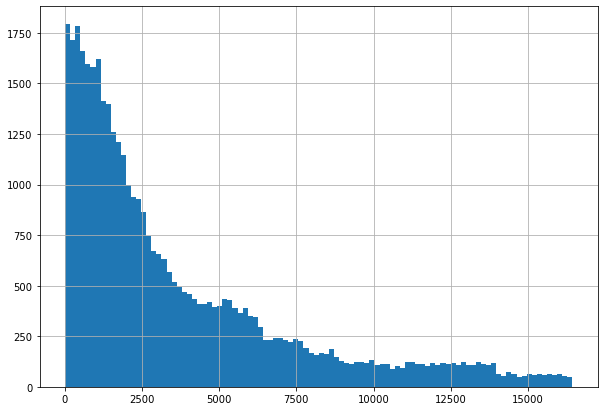

In [120]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

<AxesSubplot:>

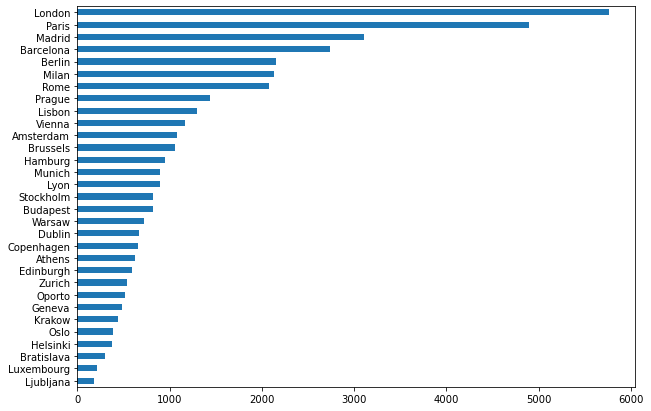

In [121]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

<AxesSubplot:>

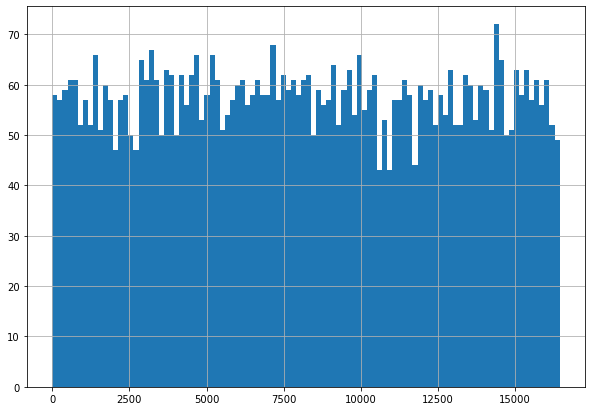

In [122]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

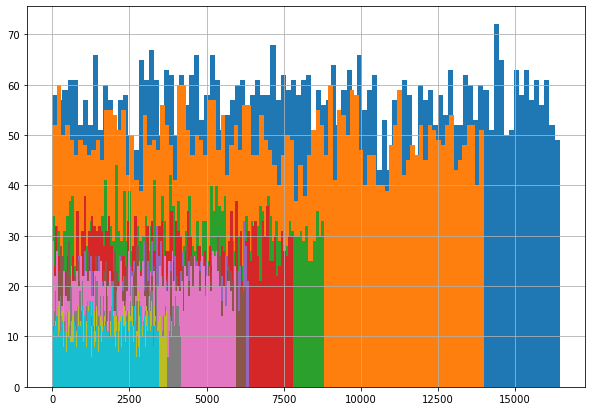

In [123]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

### Посмотрим распределение целевой переменной

<AxesSubplot:>

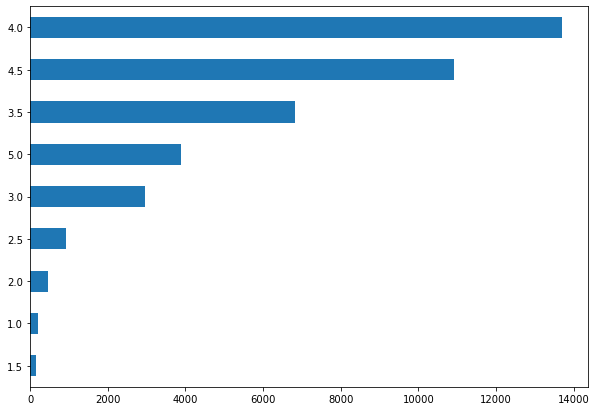

In [124]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

<AxesSubplot:>

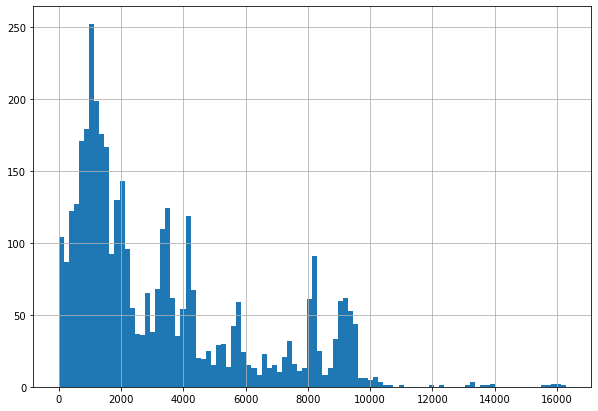

In [125]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

<AxesSubplot:>

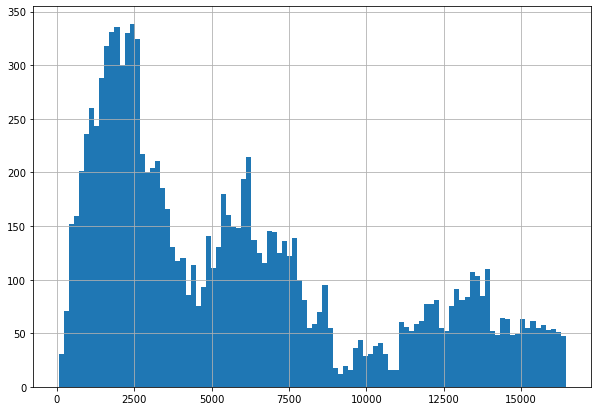

In [126]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

In [127]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Restaurant_id                   50000 non-null  object 
 1   City                            50000 non-null  object 
 2   Cuisine Style                   50000 non-null  object 
 3   Ranking                         50000 non-null  float64
 4   Price Range                     50000 non-null  object 
 5   Number of Reviews               50000 non-null  float64
 6   Reviews                         50000 non-null  object 
 7   URL_TA                          50000 non-null  object 
 8   ID_TA                           50000 non-null  object 
 9   sample                          50000 non-null  int64  
 10  Rating                          50000 non-null  float64
 11  Number_of_Cuisine_Style_isNAN   50000 non-null  uint8  
 12  Price_Range_isNAN               

# **Закодируем "Cuisine Style" и 'City'**

In [128]:
# закодируем City Способом One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

Напишем функцию, которая проведет кодирование,    
но предварительно из уникальных кухонь удалим local    
т.к. данный столбец будет полностью повторять 'Number_of_Cuisine_Style_isNAN'


In [129]:
unique_cuisine_style.remove("local")

for cuisine in unique_cuisine_style:
    cuisine_array = list() # лист для добавления в датафрейм
    for cuisine_data in data["Cuisine Style"]:
        if cuisine in cuisine_data:
            cuisine_array.append(1)
        else:
            cuisine_array.append(0)
    data[cuisine] = cuisine_array

<ipython-input-129-bd023561d200>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[cuisine] = cuisine_array


### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

<AxesSubplot:>

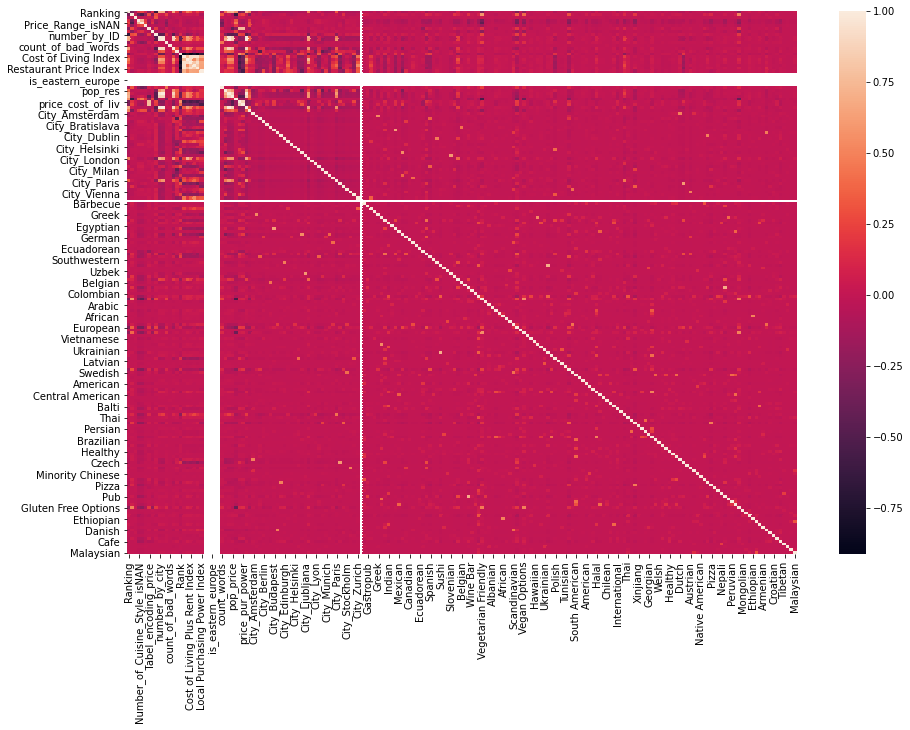

In [130]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr())

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

#### Запускаем и проверяем что получилось

In [131]:
# Удалим все object признаки
for i in data:
    if data[i].dtype == object:
        data.drop(i,axis=1,inplace = True)

In [132]:
df_preproc = data

In [133]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [134]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [135]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 193), (40000, 193), (40000, 192), (32000, 192), (8000, 192))

# Model 
Сам ML

In [136]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [137]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [138]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

# # Округлим предсказанные значения до степени округления целевой переменной

def rating(prediction):
        if prediction < 0.25:
            return 0
        elif 0.25 < prediction <= 0.75:
            return 0.5
        elif 0.75 < prediction <= 1.25:
            return 1
        elif 1.25 < prediction <= 1.75:
            return 1.5
        elif 1.75 < prediction <= 2.25:
            return 2
        elif 2.25 < prediction <= 2.75:
            return 2.5
        elif 2.75 < prediction <= 3.25:
            return 3
        elif 3.25 < prediction <= 3.75:
            return 3.5
        elif 3.75 < prediction <= 4.25:
            return 4
        elif 4.25 < prediction <= 4.75:
            return 4.5
        else:
            return 5
        
for i in range(y_pred.size):
        y_pred[i]=rating(y_pred[i])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [139]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1778125


<AxesSubplot:>

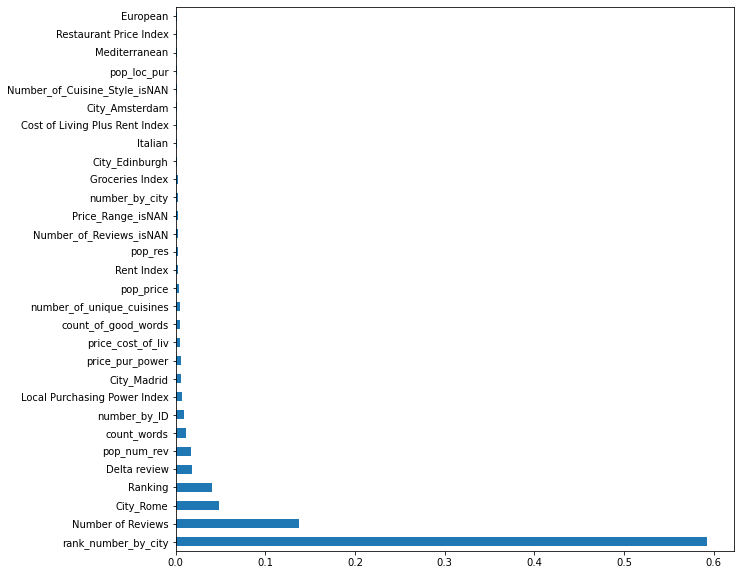

In [140]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['Rating'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
# Применим постпроцессинг
for i in range(predict_submission.size):
        predict_submission[i]=rating(predict_submission[i])

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)